In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from tqdm.notebook import tqdm

In [2]:
# THIS IS ADITYA'S CODE
def rotation_matrix(axis: torch.Tensor, theta: torch.Tensor, homogeneous: bool = False) -> torch.Tensor:
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    #axis = np.asarray(axis)

    # TODO: hacky broadcasting
    theta = theta[..., None]
    axis, theta = torch.broadcast_tensors(axis, theta)
    theta = theta[..., 0] # the last dimension gets broadcasted to "3", so truncate

    axis = axis / torch.norm(axis, 2, dim=-1)[..., None]
    a = torch.cos(theta / 2.0)
    # Transpose so we can unpack into variables
    b, c, d = torch.unbind(-axis * torch.sin(theta / 2.0)[..., None], dim=-1)

    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    mat =  torch.stack([torch.stack([aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)], dim=-1),
                        torch.stack([2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)], dim=-1),
                        torch.stack([2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc], dim=-1)],
                       dim=-2)

    if not homogeneous:
        return mat

    extra_dims = axis.shape[:-1]
    zeros_column = torch.zeros_like(mat)[..., :, 0:1] # shape: (..., 3, 1)
    hstacked = torch.cat([mat, zeros_column], dim=-1) # shape: (..., 3, 4)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)

def translation_matrix(tvec: torch.Tensor) -> torch.Tensor:
    extra_dims = tvec.shape[:-1]
    eye_tiled = torch.eye(3, dtype=tvec.dtype).to(tvec.device).repeat(extra_dims + (1, 1))
    hstacked = torch.cat([eye_tiled, tvec[..., :, None]], dim=-1)

    hom_row = torch.cat((torch.zeros_like(hstacked)[..., :1, :3],
                         torch.ones_like(hstacked)[..., :1, 3:]), dim=-1) # shape: (..., 1, 4)
    return torch.cat((hstacked, hom_row), dim=-2)
def dofs2mat(dofs):
    T = dofs[..., :3]
    angle = dofs[..., 3:].norm(dim=-1)
    axis = dofs[..., 3:]/angle[..., None]
    rot_mat = rotation_matrix(axis, angle, homogeneous=True)
    trans_mat = translation_matrix(T)
    return trans_mat @ rot_mat

def to_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = torch.cat((X, torch.ones(X.shape[:-1]+(1,))), dim=-1)
    X = X.transpose(dim, -1)
    return X
def from_homo(X, dim=-1):
    X = X.transpose(dim, -1)
    X = X[..., :-1]/X[..., -1, None]
    X = X.transpose(dim, -1)
    return X

In [3]:
f = 1.
m_x, m_y = 1., 1.
u_0, v_0 = 0., 0.

rest_dofs = torch.zeros(6)
rest_dofs[3] = 2*np.pi

In [4]:
def project_to_cam(X_w, dofs_cam=rest_dofs, f=f, m=(m_x, m_y), uv=(u_0, v_0), ret_vis_mask=False):
    
    X_w = to_homo(X_w)
    X_c = (dofs2mat(dofs_cam) @ (X_w[..., None]))[..., 0]
    vis_mask = from_homo(X_c)[..., 2]>0.
    mat_in = torch.tensor([[f*m[0], 0., uv[0], 0.],
                           [0., f*m[1], uv[1], 0.],
                           [0., 0., 1., 0.]])
    X_i = (mat_in@(X_c[..., None]))[..., 0]
    X_i = from_homo(X_i)
    if ret_vis_mask:
        return X_i, vis_mask
    return X_i

In [5]:
dofs_cam = rest_dofs.clone()
dofs_cam[2] = 0
# dofs_cam[3:] = torch.tensor([0., np.pi/7, 0.])

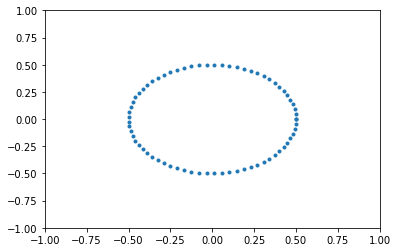

In [6]:
X = torch.cos(torch.linspace(0, 2*np.pi, 70))
Y = torch.sin(torch.linspace(0, 2*np.pi, 70))
Z = 2*torch.ones_like(X)
X_w = torch.stack((X, Y, Z), axis=-1)
X_i = project_to_cam(X_w, dofs_cam)
plt.scatter(X_i[:, 0], X_i[:, 1], marker='.')
plt.xlim(-1, 1);plt.ylim(-1, 1);
plt.show()

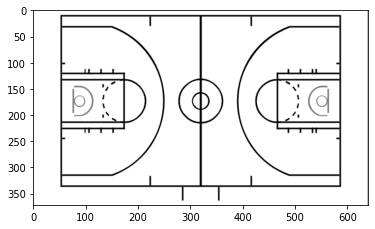

In [7]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
plt.imshow(img)
plt.show()

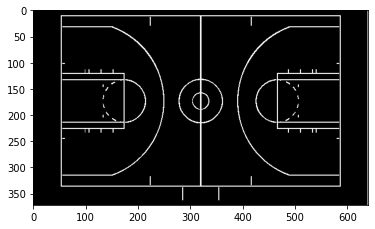

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.imshow(binary, cmap='gray')
plt.show()

In [9]:
scale = binary.shape[0]
y = (np.arange(binary.shape[0])-binary.shape[0]/2.)/scale
x = (np.arange(binary.shape[1])-binary.shape[1]/2.)/scale
y, x = np.meshgrid(y, x, indexing='ij')
z, x = y[binary], x[binary]
y = np.zeros_like(x)

In [10]:
dofs_cam = rest_dofs.clone()
dofs_cam[:3] = torch.tensor([.5, -0.5, 1.0])
dofs_cam[3:] = torch.tensor([0., np.pi/10, 0.])

In [11]:
def show_cam_view(X_w, dofs_cam=rest_dofs, f=f, m=(m_x, m_y), uv=(u_0, v_0)):
    X_i, vis_mask = project_to_cam(X_w, dofs_cam, f, m, uv, ret_vis_mask=True)
    X_i = X_i[vis_mask]
    plt.figure(figsize=(5, 5*m[1]/m[0]))
    plt.scatter(X_i[:, 0], X_i[:, 1], marker='.')
    plt.xlim(-m[0]+uv[0], m[0]+uv[0]);plt.ylim(-m[1]+uv[1], m[1]+uv[1])
    plt.show()

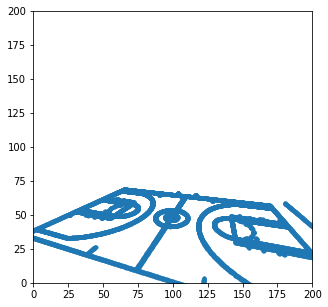

In [12]:
X_w = torch.from_numpy(np.stack((x, y, z), axis=-1)).float()

dofs_cam = rest_dofs.clone()
dofs_cam[:3] = torch.tensor([0., -0.5, 1.0])
dofs_cam[3:] = torch.tensor([0., np.pi/10, 0.])


show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))

In [13]:
def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values
    

In [14]:
X_w = X_w[::10, :]

# Rendering Loss

In [52]:
dofs_cam_optim = dofs_cam.clone()
torch.manual_seed(10)
dofs_cam_optim+=0.2*torch.randn(dofs_cam_optim.shape)

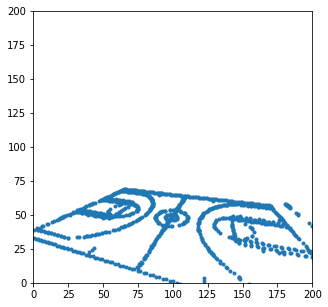

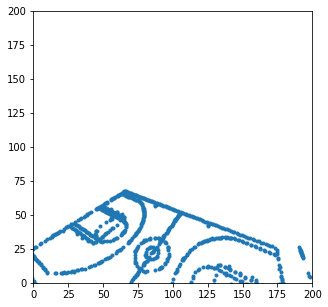

In [53]:
show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))
show_cam_view(X_w, dofs_cam_optim, f, (100., 100.), (100, 100))

In [54]:
opt = torch.optim.Adam([dofs_cam_optim], lr=0.003)
dofs_cam_optim.requires_grad_()

for _ in tqdm(range(200)):
    X_i, vis_mask = project_to_cam(X_w, dofs_cam_optim, f, ret_vis_mask=True)
    X_i = X_i[vis_mask]
#     X_true = get_true()

    X_true, vis_mask = project_to_cam(X_w, dofs_cam, f, ret_vis_mask=True)
    X_true = X_true[vis_mask]
    
    loss = pt2pt_dist(X_i, X_true)
    loss = loss.mean()
    print(loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    


dofs_cam_optim = dofs_cam_optim.detach()

0.2311573624610901
0.22354868054389954
0.21629966795444489
0.209428608417511
0.20290130376815796
0.19660864770412445
0.1905689239501953
0.18464916944503784
0.17875102162361145
0.1729109287261963
0.1671774536371231
0.16144786775112152
0.1558874249458313
0.15053503215312958
0.14523591101169586
0.13993288576602936
0.13474999368190765
0.12973207235336304
0.1249433234333992
0.12033010274171829
0.11562325060367584
0.1110818162560463
0.10672085732221603
0.10240299254655838
0.09796085953712463
0.09365002065896988
0.08960488438606262
0.08597322553396225
0.08285897970199585
0.08017196506261826
0.07781454920768738
0.0755392536520958
0.07342282682657242
0.07134293764829636
0.06922905147075653
0.06718934327363968
0.06528452038764954
0.06339628994464874
0.06145029515028
0.05949215590953827
0.057551879435777664
0.05559288710355759
0.05353697016835213
0.051326677203178406
0.0489632785320282
0.0464957170188427
0.04393303394317627
0.04131433740258217
0.03863587975502014
0.03587067872285843
0.03300162032

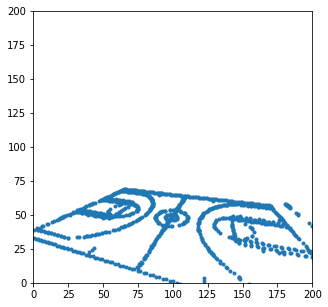

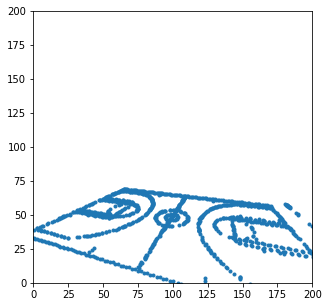

In [55]:
show_cam_view(X_w, dofs_cam, f, (100., 100.), (100, 100))
show_cam_view(X_w, dofs_cam_optim, f, (100., 100.), (100, 100))